In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [8]:
# Build the model

class MyModel(Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(10)
        self.dense3 = Dense(5)
        self.softmax = Softmax()
        #self.dropout = Dropout(0.5)
        
    def call(self, inputs, Training=True):
        x = self.dense1(inputs)
        y1 = self.dense2(inputs)
        y2 = self.dense3(y1)
        concat = concatenate([x,y2])
#         if Training:
#             x = self.dropout(x)

        return self.softmax(concat)

In [9]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              multiple                  704       
_________________________________________________________________
dense_8 (Dense)              multiple                  110       
_________________________________________________________________
dense_9 (Dense)              multiple                  55        
_________________________________________________________________
softmax_1 (Softmax)          multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [15]:
# Create a custom layer

class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
        self.b = self.add_weight(shape=(units), initializer='zeros')
    
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


In [17]:
dense_layer = MyLayer(3, 5)
x = tf.ones((1,5))

print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[-0.076607   -0.00956125  0.0631026 ]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.03864897, -0.03158235,  0.06690072],
       [-0.15041804,  0.04570355, -0.05178002],
       [ 0.04873775, -0.05855143,  0.11001752],
       [-0.05093267, -0.02183552, -0.03929253],
       [ 0.03735699,  0.0567045 , -0.02274309]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [18]:
# Specify trainable weights

class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal', trainable=False)
        self.b = self.add_weight(shape=(units), initializer='zeros')
    
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
dense_layer = MyLayer(3, 5)

In [19]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 1
non-trainable weights: 1


In [28]:
# Create a custom layer to accumulate means of output values

class MyLayerMean(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
        self.b = self.add_weight(shape=(units), initializer='zeros')
        self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)), trainable=False)
        self.number_of_times_called = tf.Variable(initial_value=0, trainable=False)
    
    def call(self, inputs):
        
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_of_times_called.assign_add(inputs.shape[0])
        
        return activations, self.sum_activation/tf.cast(self.number_of_times_called, tf.float32)

dense_layer = MyLayerMean(3,5)

In [31]:
# Test the layer

y, activation_means = dense_layer(tf.ones((2, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((25, 5)))
print(activation_means.numpy())

[-0.10821151  0.09168078  0.00371452]
[-0.10821151  0.09168078  0.00371452]


In [32]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, self.rate)

#### Implement the custom layers into a model

In [33]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.fc1 = MyLayer(units_1, input_dim_1)
        self.do1 = MyDropout(0.5)
        self.fc2 = MyLayer(units_2, units_1)
        self.do2 = MyDropout(0.5)
        self.fc3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.fc1(inputs)
        x = tf.nn.relu(x)
        x = self.do1(x)
        
        x = self.fc2(x)
        x = tf.nn.relu(x)
        x = self.do2(x)
        
        x = self.fc3(x)
       
        return self.softmax(x)

In [34]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.0069214  0.02376164 0.00765234 0.00897997 0.02400807 0.02655453
  0.01470018 0.01380537 0.00909741 0.00946805 0.03031897 0.05255055
  0.00804285 0.07187328 0.01164568 0.00899165 0.01150675 0.01172656
  0.0093837  0.01070452 0.02787809 0.01325259 0.01747757 0.01285255
  0.04323637 0.00950964 0.00677221 0.03577766 0.02471427 0.06167721
  0.0044905  0.04209806 0.04051574 0.00325791 0.05219585 0.01466668
  0.02039598 0.00980926 0.01119609 0.01316375 0.00640665 0.07552409
  0.01528005 0.01959507 0.02083821 0.02572445]], shape=(1, 46), dtype=float32)
Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_5 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_6 (MyLaye

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [35]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

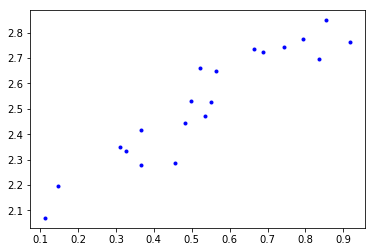

In [36]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [37]:
from tensorflow.keras.layers import Layer

In [39]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):
    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape=(1,), initializer='random_normal')
        self.b = self.add_weight(shape=(1,), initializer='random_normal')
    
    def call(self, inputs):
        return self.m * inputs + self.b
    
linear_regression = LinearLayer()

#### Define the loss function

In [40]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.2821264


#### Train and plot the model

In [43]:
# Implement a gradient descent training loop for the linear regression model

steps = 30
lr = 0.05

for i in range(steps):
    
    with tf.GradientTape() as tape:
        
        predictions = linear_regression(x_train)
        loss = SquaredError(predictions, y_train)
        
    gradients = tape.gradient(loss, linear_regression.trainable_weights)
        
    linear_regression.m.assign_sub(lr * gradients[0])
    linear_regression.b.assign_sub(lr * gradients[1])
    print(f"Loss after epoch {i+1} : {loss}")

Loss after epoch 1 : 5.374980926513672
Loss after epoch 2 : 4.070504188537598
Loss after epoch 3 : 3.083034038543701
Loss after epoch 4 : 2.3355326652526855
Loss after epoch 5 : 1.769684076309204
Loss after epoch 6 : 1.341343641281128
Loss after epoch 7 : 1.0170947313308716
Loss after epoch 8 : 0.7716414928436279
Loss after epoch 9 : 0.5858351588249207
Loss after epoch 10 : 0.4451807141304016
Loss after epoch 11 : 0.33870548009872437
Loss after epoch 12 : 0.25810348987579346
Loss after epoch 13 : 0.1970871388912201
Loss after epoch 14 : 0.15089678764343262
Loss after epoch 15 : 0.1159295067191124
Loss after epoch 16 : 0.08945782482624054
Loss after epoch 17 : 0.06941728293895721
Loss after epoch 18 : 0.05424501374363899
Loss after epoch 19 : 0.04275797680020332
Loss after epoch 20 : 0.03406059369444847
Loss after epoch 21 : 0.027474969625473022
Loss after epoch 22 : 0.022487901151180267
Loss after epoch 23 : 0.018710941076278687
Loss after epoch 24 : 0.01585003361105919
Loss after epoc

m:1,  trained m:[1.0396515]
b:2,  trained b:[1.9281613]


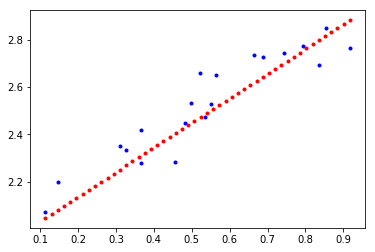

In [44]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [17]:
# Define the custom layers and model

class MyLayer(Layer):
    
    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', name='kernel')
        self.b = self.add_weight(shape=(self.units), initializer='zeros', name='bias')
    
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, self.rate)
    
class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.fc1 = MyLayer(units_1)
        self.do1 = MyDropout(0.5)
        self.fc2 = MyLayer(units_2)
        self.do2 = MyDropout(0.5)
        self.fc3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.fc1(inputs)
        x = tf.nn.relu(x)
        x = self.do1(x)
        
        x = self.fc2(x)
        x = tf.nn.relu(x)
        x = self.do2(x)
        
        x = self.fc3(x)
       
        return self.softmax(x)
    
model = MyModel(64,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.01578664 0.00857779 0.02634911 0.03754414 0.01169619 0.02595064
  0.02463659 0.02443359 0.01847834 0.03965329 0.00906289 0.02003738
  0.00992668 0.00864463 0.01358816 0.08443103 0.0126432  0.01175363
  0.02405392 0.04818554 0.04128646 0.01532383 0.04037536 0.02131099
  0.00390778 0.00996401 0.01648767 0.00679411 0.06894042 0.00674838
  0.0315888  0.01791004 0.00694038 0.0351826  0.01490395 0.01277871
  0.01719942 0.02656671 0.02953229 0.01615123 0.01191233 0.01574645
  0.00963369 0.02665044 0.00846419 0.01226634]], shape=(1, 46), dtype=float32)
Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_3 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_2 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_4 (MyLaye

#### Load the reuters dataset and define the class_names 

In [4]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2113536/2110848 [==============================] - 0s 0us/step


In [5]:
print(f"Train data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train data shape: (8982,)
Train labels shape: (8982,)
Test data shape: (2246,)
Test labels shape: (2246,)


In [6]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [7]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [8]:
# Print the first data example sentence

text_news

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

#### Preprocess the data

In [9]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [10]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [23]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [24]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))    
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    
    epoch_loss_average = tf.keras.metrics.Mean()
    epoch_accuracy_average = tf.keras.metrics.CategoricalAccuracy()
    
    for x,y in train_dataset:
        curr_loss, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss_average(curr_loss)
        epoch_accuracy_average(to_categorical(y), model(x))
    
    train_loss_results.append(epoch_loss_average.result())
    train_accuracy_results.append(epoch_accuracy_average.result())
    
    print(f"Epoch: {epoch+1}  Loss: {epoch_loss_average.result():.3f}  Accuracy: {epoch_accuracy_average.result():.2%}")
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch: 1  Loss: 3.259  Accuracy: 49.91%
Epoch: 2  Loss: 1.885  Accuracy: 63.04%
Epoch: 3  Loss: 1.811  Accuracy: 66.46%
Epoch: 4  Loss: 1.754  Accuracy: 67.85%
Epoch: 5  Loss: 1.752  Accuracy: 68.56%
Epoch: 6  Loss: 1.741  Accuracy: 68.64%
Epoch: 7  Loss: 1.718  Accuracy: 69.39%
Epoch: 8  Loss: 1.718  Accuracy: 69.78%
Epoch: 9  Loss: 1.705  Accuracy: 70.21%
Epoch: 10  Loss: 1.716  Accuracy: 70.63%
Duration :231.637


#### Evaluate the model

In [25]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [26]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [27]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.849
Test accuracy: 67.008%


#### Plot the learning curves

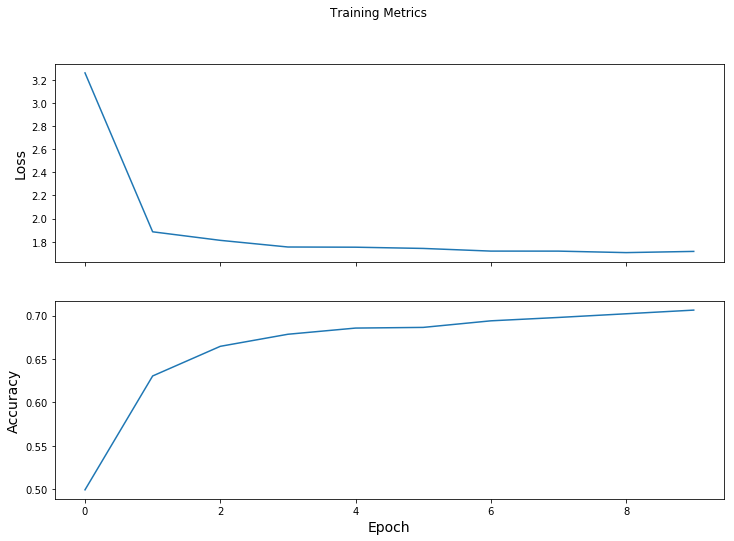

In [28]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [29]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [3]:
# Initialize a new model

# Define the custom layers and model

class MyLayer(Layer):
    
    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', name='kernel')
        self.b = self.add_weight(shape=(self.units), initializer='zeros', name='bias')
    
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, self.rate)
    
class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.fc1 = MyLayer(units_1)
        self.do1 = MyDropout(0.5)
        self.fc2 = MyLayer(units_2)
        self.do2 = MyDropout(0.5)
        self.fc3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.fc1(inputs)
        x = tf.nn.relu(x)
        x = self.do1(x)
        
        x = self.fc2(x)
        x = tf.nn.relu(x)
        x = self.do2(x)
        
        x = self.fc3(x)
       
        return self.softmax(x)
    
model = MyModel(64,64,46)

#### Redefine the grad function using the @tf.function decorator

In [11]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [12]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))    
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    
    epoch_loss_average = tf.keras.metrics.Mean()
    epoch_accuracy_average = tf.keras.metrics.CategoricalAccuracy()
    
    for x,y in train_dataset:
        curr_loss, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss_average(curr_loss)
        epoch_accuracy_average(to_categorical(y), model(x))
    
    train_loss_results.append(epoch_loss_average.result())
    train_accuracy_results.append(epoch_accuracy_average.result())
    
    print(f"Epoch: {epoch+1}  Loss: {epoch_loss_average.result():.3f}  Accuracy: {epoch_accuracy_average.result():.2%}")
    
print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 1  Loss: 3.307  Accuracy: 49.08%
Epoch: 2  Loss: 1.919  Accuracy: 61.00%
Epoch: 3  Loss: 1.849  Accuracy: 65.39%
Epoch: 4  Loss: 1.796  Accuracy: 67.96%
Epoch: 5  Loss: 1.758  Accuracy: 68.92%
Epoch: 6  Loss: 1.733  Accuracy: 69.54%
Epoch: 7  Loss: 1.721  Accuracy: 70.06%
Epoch: 8  Loss: 1.717  Accuracy: 70.50%
Epoch: 9  Loss: 1.707  Accuracy: 70.51%
Epoch: 10  Loss: 1.710  Accuracy: 70.92%
Duration :204.959


#### Print the autograph code

In [14]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('grad', 'grad_scope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as grad_scope:
    with tf.GradientTape() as tape:
      loss_value = ag__.converted_call(loss, grad_scope.callopts, (model, inputs, targets, wd), None, grad_scope)
    do_return = True
    retval_ = grad_scope.mark_return_value((loss_value, ag__.converted_call(tape.gradient, grad_scope.callopts, (loss_value, model.trainable_variables), None, grad_scope)))
  do_return,
  return ag__.retval(retval_)

